#FINRL Train Stock Trading
https://github.com/AI4Finance-LLC/FinRL/blob/master/finrl/train.py

In this work SAC used as RL agorithm rather than D Q-Network. The reason of this choice explained in "Train Model" section.

Multi-stock trading data used in train and trade data part. So this work related to multi-stock trading with RL. DOW The latest market data for all 30 stocks in the Dow Jones Industrial Average. So in this work there is "BIST_30_TICKER" relates with that.



#SETUP

In [1]:
 # Install the unstable development version in Jupyter notebook:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-ukx9qhlp
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-ukx9qhlp
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-haxkimbn/pyfolio_84da37d84ccd485abb835a347a3c0da3
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-haxkimbn/pyfolio_84da37d84ccd485abb835a347a3c0da3


In [2]:
#for data download part -- yahoo finance
!pip install yfinance

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing

matplotlib.use("Agg")
import datetime

from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading_stoploss import StockTradingEnvStopLoss
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

import itertools


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [4]:
import pandas as pd
import yfinance as yf

#Collect Data

In [5]:
stockList = ["AKBNK.IS","ARCLK.IS","ASELS.IS","BIMAS.IS","DOHOL.IS","EKGYO.IS","EREGL.IS","FROTO.IS","GARAN.IS","GUBRF.IS","HALKB.IS","ISCTR.IS","KCHOL.IS","KOZAA.IS","KOZAL.IS",
"KRDMD.IS","PETKM.IS","PGSUS.IS","SAHOL.IS","SASA.IS","SISE.IS","TAVHL.IS","TCELL.IS","THYAO.IS","TKFEN.IS","TTKOM.IS","TUPRS.IS","VAKBN.IS","VESTL.IS","YKBNK.IS"]
len(stockList)

30

In [6]:
# print("==============Start Fetching Data===========")
# df = YahooDownloader(
#     start_date=config.START_DATE,
#     end_date=config.END_DATE,
#     ticker_list=stockList,
# ).fetch_data()

In [7]:
tickers = ["VESTL.IS","VAKBN.IS","TUPRS.IS""THYAO.IS","HALKB.IS","SASA.IS","PETKM.IS","SAHOL.IS","PGSUS.IS","GARAN.IS","AKBNK.IS","ARCLK.IS","BIMAS.IS","EREGL.IS"] # 20 tane hisse


In [8]:
date1="2015-07-27"
date2="2021-07-28"
list_data = []
for ticker in tickers:
  data = yf.download(tickers=ticker , start=date1, end=date2, interval='1d' )
  data["tic"] = ticker
  data["date"] = data.index
  data = data.reset_index()
  list_data.append(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TUPRS.ISTHYAO.IS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
list_data

[           Date       Open       High  ...   Volume       tic       date
 0    2015-07-27   4.450000   4.450000  ...  1074220  VESTL.IS 2015-07-27
 1    2015-07-28   4.450000   4.470000  ...  1609540  VESTL.IS 2015-07-28
 2    2015-07-29   4.430000   4.460000  ...   981396  VESTL.IS 2015-07-29
 3    2015-07-30   4.480000   4.490000  ...   871776  VESTL.IS 2015-07-30
 4    2015-07-31   4.480000   4.650000  ...  6003500  VESTL.IS 2015-07-31
 ...         ...        ...        ...  ...      ...       ...        ...
 1526 2021-07-14  30.420000  31.440001  ...  2070274  VESTL.IS 2021-07-14
 1527 2021-07-16  31.420000  31.620001  ...  1660750  VESTL.IS 2021-07-16
 1528 2021-07-19  31.400000  32.160000  ...  1369061  VESTL.IS 2021-07-19
 1529 2021-07-26  32.200001  32.279999  ...  2489134  VESTL.IS 2021-07-26
 1530 2021-07-27  31.980000  32.099998  ...  1726049  VESTL.IS 2021-07-27
 
 [1531 rows x 9 columns],
            Date  Open  High   Low  ...  Adj Close    Volume       tic       date
 0

In [10]:
import pandas as pd
df = pd.concat(list_data)

del df['Date']

In [11]:

df.isna().sum()
multi_ticker_df = df.ffill().bfill()
print(multi_ticker_df)

           Open       High        Low  ...      Volume       tic       date
0      4.450000   4.450000   4.330000  ...   1074220.0  VESTL.IS 2015-07-27
1      4.450000   4.470000   4.370000  ...   1609540.0  VESTL.IS 2015-07-28
2      4.430000   4.460000   4.410000  ...    981396.0  VESTL.IS 2015-07-29
3      4.480000   4.490000   4.430000  ...    871776.0  VESTL.IS 2015-07-30
4      4.480000   4.650000   4.480000  ...   6003500.0  VESTL.IS 2015-07-31
...         ...        ...        ...  ...         ...       ...        ...
1526  17.990000  18.400000  17.990000  ...  19197906.0  EREGL.IS 2021-07-14
1527  18.250000  18.250000  17.910000  ...  17163796.0  EREGL.IS 2021-07-16
1528  18.000000  18.030001  17.850000  ...   5709839.0  EREGL.IS 2021-07-19
1529  18.040001  18.250000  18.000000  ...  23665915.0  EREGL.IS 2021-07-26
1530  18.070000  18.490000  17.969999  ...  25081610.0  EREGL.IS 2021-07-27

[18372 rows x 8 columns]


In [12]:
type(multi_ticker_df)

pandas.core.frame.DataFrame

In [13]:
multi_ticker_df.columns= multi_ticker_df.columns.str.strip().str.lower()
multi_ticker_df.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'tic', 'date'], dtype='object')

In [14]:
def prefill(multi_ticker_df)  :
    df = multi_ticker_df.copy()
    df=df.sort_values(['date','tic'],ignore_index=True)
    df.index = df.date.factorize()[0]
    merged_closes = df.pivot_table(index = 'date',columns = 'tic', values = 'close')

    print(merged_closes.isna().sum())
    merged_closes = merged_closes.ffill().bfill()

    # print(merged_closes.isna().sum())
    # print(merged_closes)
    tics = merged_closes.columns
    df = df[df.tic.isin(tics)]
    df = df.reset_index()
    del df['index']
    return df
multiticker_df = prefill(multi_ticker_df)


tic
AKBNK.IS    0
ARCLK.IS    0
BIMAS.IS    0
EREGL.IS    0
GARAN.IS    0
HALKB.IS    0
PETKM.IS    0
PGSUS.IS    0
SAHOL.IS    0
SASA.IS     0
VAKBN.IS    0
VESTL.IS    0
dtype: int64


In [15]:
print(multiticker_df)

            open       high        low  ...      volume       tic       date
0       6.182181   6.182181   6.122160  ...  13466375.0  AKBNK.IS 2015-07-27
1      14.750000  14.950000  14.500000  ...   1976842.0  ARCLK.IS 2015-07-27
2      23.525000  23.799999  23.325001  ...    628882.0  BIMAS.IS 2015-07-27
3       3.990000   4.040000   3.960000  ...   6776403.0  EREGL.IS 2015-07-27
4       7.900000   7.910000   7.740000  ...  63095366.0  GARAN.IS 2015-07-27
...          ...        ...        ...  ...         ...       ...        ...
18367  67.699997  71.949997  67.199997  ...   3505926.0  PGSUS.IS 2021-07-27
18368   9.070000   9.300000   9.020000  ...  17634418.0  SAHOL.IS 2021-07-27
18369  29.680000  30.299999  29.340000  ...  15605997.0   SASA.IS 2021-07-27
18370   3.430000   3.440000   3.390000  ...  30871452.0  VAKBN.IS 2021-07-27
18371  31.980000  32.099998  31.740000  ...   1726049.0  VESTL.IS 2021-07-27

[18372 rows x 8 columns]


#Feature Engineering

In [16]:
print("==============Start Feature Engineering===========")
tech_indicator_list=config.TECHNICAL_INDICATORS_LIST

fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=tech_indicator_list,
    use_turbulence=True,
    user_defined_feature=False,
)

==============Start Feature Engineering===========


In [17]:
tech_indicator_list

['macd', 'rsi_30', 'cci_30', 'dx_30']

In [18]:
processed = fe.preprocess_data(multiticker_df)


Successfully added technical indicators
Successfully added turbulence index


In [19]:
processed

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,6.182181,6.182181,6.122160,6.165032,5.510608,13466375.0,AKBNK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
1,14.750000,14.950000,14.500000,14.600000,11.878804,1976842.0,ARCLK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
2,23.525000,23.799999,23.325001,23.600000,19.072001,628882.0,BIMAS.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
3,3.990000,4.040000,3.960000,4.040000,1.965522,6776403.0,EREGL.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
4,7.900000,7.910000,7.740000,7.760000,6.942376,63095366.0,GARAN.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18367,67.699997,71.949997,67.199997,71.400002,71.400002,3505926.0,PGSUS.IS,2021-07-27,-2.136392,44.699076,-115.962311,31.513849,7.048507
18368,9.070000,9.300000,9.020000,9.290000,9.290000,17634418.0,SAHOL.IS,2021-07-27,0.000826,53.078843,5.758155,11.416987,7.048507
18369,29.680000,30.299999,29.340000,29.540001,29.540001,15605997.0,SASA.IS,2021-07-27,-0.567082,47.213518,-26.532921,13.879146,7.048507
18370,3.430000,3.440000,3.390000,3.420000,3.420000,30871452.0,VAKBN.IS,2021-07-27,-0.036190,42.210935,-143.798826,35.035782,7.048507


In [20]:
processed_full = processed.sort_values(['date','tic'])
processed_full= processed_full.ffill().bfill()

In [21]:
processed_full

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,6.182181,6.182181,6.122160,6.165032,5.510608,13466375.0,AKBNK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
1,14.750000,14.950000,14.500000,14.600000,11.878804,1976842.0,ARCLK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
2,23.525000,23.799999,23.325001,23.600000,19.072001,628882.0,BIMAS.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
3,3.990000,4.040000,3.960000,4.040000,1.965522,6776403.0,EREGL.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
4,7.900000,7.910000,7.740000,7.760000,6.942376,63095366.0,GARAN.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18367,67.699997,71.949997,67.199997,71.400002,71.400002,3505926.0,PGSUS.IS,2021-07-27,-2.136392,44.699076,-115.962311,31.513849,7.048507
18368,9.070000,9.300000,9.020000,9.290000,9.290000,17634418.0,SAHOL.IS,2021-07-27,0.000826,53.078843,5.758155,11.416987,7.048507
18369,29.680000,30.299999,29.340000,29.540001,29.540001,15605997.0,SASA.IS,2021-07-27,-0.567082,47.213518,-26.532921,13.879146,7.048507
18370,3.430000,3.440000,3.390000,3.420000,3.420000,30871452.0,VAKBN.IS,2021-07-27,-0.036190,42.210935,-143.798826,35.035782,7.048507


# Training & Trading data split

In [22]:
date1="2015-07-27"
date2="2021-07-28"
date3= "2020-07-27"

In [23]:
train = data_split(processed_full,date1, date3)
trade = data_split(processed_full, date3, date2)


# Calculate state action space


In [24]:
stock_dimension = len(train.tic.unique()) # number of tickers
state_space = (
        1
        + 2 * stock_dimension
        + len(config.TECHNICAL_INDICATORS_LIST) * stock_dimension)

In [25]:
stock_dimension ,state_space

(12, 73)

# ENV CREATE

In [26]:
env_kwargs = {
      
        "initial_amount": 10000, 
}

In [ ]:
import numpy as np
import pandas as pd
from copy import deepcopy
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import random
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common import logger
import time
class StockTradingEnvStopLoss(gym.Env):
    """
    A stock trading environment for OpenAI gym
    This environment penalizes the model if excedeed the stop-loss threshold, selling assets with under expectation %profit, and also  
    for not maintaining a reserve of cash.
    This enables the model to do trading with high confidence and manage cash reserves in addition to performing trading procedures.

    Reward at any step is given as follows
        r_i = (sum(cash, asset_value) + additional_reward - total_penalty - initial_cash) / initial_cash / days_elapsed
        , where total_penalty = cash_penalty + stop_loss_penalty + low_profit_penalty
                cash_penalty = max(0, sum(cash, asset_value)*cash_penalty_proportion-cash)
                stop_loss_penalty = -1 * dot(holdings,negative_closing_diff_avg_buy)
                low_profit_penalty = -1 * dot(holdings,negative_profit_sell_diff_avg_buy)
                additional_reward = dot(holdings,positive_profit_sell_diff_avg_buy)

        This reward function takes into account a profit/loss ratio constraint, liquidity requirement, as well as long-term accrued rewards.
        This reward function also forces the model to trade only when it's really confident to do so.

    Parameters:
    state space: {start_cash, <owned_shares>, for s in stocks{<stock.values>}, }
        df (pandas.DataFrame): Dataframe containing data
        buy_cost_pct (float): cost for buying shares
        sell_cost_pct (float): cost for selling shares
        hmax (int): max number of share purchases allowed per asset
        discrete_actions (bool): option to choose whether perform dicretization on actions space or not
        shares_increment (int): multiples number of shares can be bought in each trade.
        stoploss_penalty (float): Maximum loss we can tolerate. Valid value range is between 0 and 1. If x is specified, then agent will force sell all holdings for a particular asset if current price < x * avg_buy_price 
        profit_loss_ratio (int, float): Expected profit/loss ratio. Only applicable when stoploss_penalty < 1.
        turbulence_threshold (float): Maximum turbulence allowed in market for purchases to occur. If exceeded, positions are liquidated
        print_verbosity(int): When iterating (step), how often to print stats about state of env
        initial_amount: (int, float): Amount of cash initially available
        daily_information_columns (list(str)): Columns to use when building state space from the dataframe. It could be OHLC columns or any other variables such as technical indicators and turbulence index
        cash_penalty_proportion (int, float): Penalty to apply if the algorithm runs out of cash
        patient (bool): option to choose whether end the cycle when we're running out of cash or just don't buy anything until we got additional cash 
    action space: <share_dollar_purchases>
    TODO:
        add holdings to memory
        move transactions to after the clip step.
    tests:
        after reset, static strategy should result in same metrics
        given no change in prices, no change in asset values
    """
    metadata = {"render.modes": ["human"]}
    def __init__(
        self,
        df,
        buy_cost_pct=3e-3,
        sell_cost_pct=3e-3,
        date_col_name="date",
        hmax=10,
        discrete_actions=False,
        shares_increment=1,
        stoploss_penalty=0.9,
        profit_loss_ratio=2,
        turbulence_threshold=None,
        print_verbosity=10,
        initial_amount=1e6,
        daily_information_cols=["open", "close", "high", "low", "volume"],
        cache_indicator_data=True,
        cash_penalty_proportion=0.1,
        random_start=True,
        patient=False,
        currency="$",
    ):
        self.df = df
        self.stock_col = "tic"
        self.assets = df[self.stock_col].unique()
        self.dates = df[date_col_name].sort_values().unique()
        self.random_start = random_start
        self.discrete_actions = discrete_actions
        self.patient = patient
        self.currency = currency
        self.df = self.df.set_index(date_col_name)
        self.shares_increment = shares_increment
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.print_verbosity = print_verbosity
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.stoploss_penalty = stoploss_penalty
        self.min_profit_penalty  = 1 + profit_loss_ratio * (1 - self.stoploss_penalty) 
        self.turbulence_threshold = turbulence_threshold
        self.daily_information_cols = daily_information_cols
        self.state_space = (
            1 + len(self.assets) + len(self.assets) * len(self.daily_information_cols)
        )
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.assets),))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.turbulence = 0
        self.episode = -1  # initialize so we can call reset
        self.episode_history = []
        self.printed_header = False
        self.cache_indicator_data = cache_indicator_data
        self.cached_data = None
        self.cash_penalty_proportion = cash_penalty_proportion
        if self.cache_indicator_data:
            print("caching data")
            self.cached_data = [
                self.get_date_vector(i) for i, _ in enumerate(self.dates)
            ]
            print("data cached!")
    def seed(self, seed=None):
        if seed is None:
            seed = int(round(time.time() * 1000))
        random.seed(seed)
    @property
    def current_step(self):
        return self.date_index - self.starting_point
    def reset(self):
        self.seed()
        self.sum_trades = 0
        self.actual_num_trades = 0
        self.closing_diff_avg_buy = np.zeros(len(self.assets))
        self.profit_sell_diff_avg_buy = np.zeros(len(self.assets))
        self.n_buys = np.zeros(len(self.assets))
        self.avg_buy_price = np.zeros(len(self.assets))
        if self.random_start:
            starting_point = random.choice(range(int(len(self.dates) * 0.5)))
            self.starting_point = starting_point
        else:
            self.starting_point = 0
        self.date_index = self.starting_point
        self.turbulence = 0
        self.episode += 1
        self.actions_memory = []
        self.transaction_memory = []
        self.state_memory = []
        self.account_information = {
            "cash": [],
            "asset_value": [],
            "total_assets": [],
            "reward": [],
        }
        init_state = np.array(
            [self.initial_amount]
            + [0] * len(self.assets)
            + self.get_date_vector(self.date_index)
        )
        self.state_memory.append(init_state)
        return init_state
    def get_date_vector(self, date, cols=None):
        if (cols is None) and (self.cached_data is not None):
            return self.cached_data[date]
        else:
            date = self.dates[date]
            if cols is None:
                cols = self.daily_information_cols
            trunc_df = self.df.loc[[date]]
            v = []
            for a in self.assets:
                subset = trunc_df[trunc_df[self.stock_col] == a]
                v += subset.loc[date, cols].tolist()
            assert len(v) == len(self.assets) * len(cols)
            return v
    def return_terminal(self, reason="Last Date", reward=0):
        state = self.state_memory[-1]
        self.log_step(reason=reason, terminal_reward=reward)
        # Add outputs to logger interface
        gl_pct = self.account_information["total_assets"][-1] / self.initial_amount
        print("environment/GainLoss_pct",(gl_pct - 1)*100)
        print(
            "environment/total_assets",
            int(self.account_information["total_assets"][-1]),
        )
        reward_pct = self.account_information["total_assets"][-1] / self.initial_amount
        print("environment/total_reward_pct", (reward_pct - 1) * 100)
        print("environment/total_trades", self.sum_trades)
        print(
            "environment/actual_num_trades",
            self.actual_num_trades,
        )
        print(
            "environment/avg_daily_trades",
            self.sum_trades / (self.current_step),
        )
        print(
            "environment/avg_daily_trades_per_asset",
            self.sum_trades / (self.current_step) / len(self.assets),
        )
        print("environment/completed_steps", self.current_step)
        print(
            "environment/sum_rewards", np.sum(self.account_information["reward"])
        )
        print(
            "environment/cash_proportion",
            self.account_information["cash"][-1]
            / self.account_information["total_assets"][-1],
        )
        return state, reward, True, {}
    def log_step(self, reason, terminal_reward=None):
        if terminal_reward is None:
            terminal_reward = self.account_information["reward"][-1]
        cash_pct = (
            self.account_information["cash"][-1]
            / self.account_information["total_assets"][-1]
        )
        gl_pct = self.account_information["total_assets"][-1] / self.initial_amount
        rec = [
            self.episode,
            self.date_index - self.starting_point,
            reason,
            f"{self.currency}{'{:0,.0f}'.format(float(self.account_information['cash'][-1]))}",
            f"{self.currency}{'{:0,.0f}'.format(float(self.account_information['total_assets'][-1]))}",
            f"{terminal_reward*100:0.5f}%",
            f"{(gl_pct - 1)*100:0.5f}%",
            f"{cash_pct*100:0.2f}%",
        ]
        self.episode_history.append(rec)
        print(self.template.format(*rec))
    def log_header(self):
        self.template = "{0:4}|{1:4}|{2:15}|{3:15}|{4:15}|{5:10}|{6:10}|{7:10}"  # column widths: 8, 10, 15, 7, 10
        print(
            self.template.format(
                "EPISODE",
                "STEPS",
                "TERMINAL_REASON",
                "CASH",
                "TOT_ASSETS",
                "TERMINAL_REWARD_unsc",
                "GAINLOSS_PCT",
                "CASH_PROPORTION",
            )
        )
        self.printed_header = True
    def get_reward(self):
        if self.current_step == 0:
            return 0
        else:
            total_assets = self.account_information["total_assets"][-1]
            cash = self.account_information["cash"][-1]
            holdings = self.state_memory[-1][1 : len(self.assets) + 1]
            neg_closing_diff_avg_buy = np.clip(self.closing_diff_avg_buy, -np.inf, 0)
            neg_profit_sell_diff_avg_buy = np.clip(self.profit_sell_diff_avg_buy, -np.inf, 0)
            pos_profit_sell_diff_avg_buy = np.clip(self.profit_sell_diff_avg_buy, 0, np.inf)

            cash_penalty = max(0, (total_assets * self.cash_penalty_proportion - cash))
            if self.current_step > 1:
                prev_holdings = self.state_memory[-2][1 : len(self.assets) + 1]
                stop_loss_penalty = -1 * np.dot(np.array(prev_holdings),neg_closing_diff_avg_buy)
            else:
                stop_loss_penalty = 0
            low_profit_penalty = -1 * np.dot(np.array(holdings),neg_profit_sell_diff_avg_buy)
            total_penalty = cash_penalty + stop_loss_penalty + low_profit_penalty
            
            additional_reward = np.dot(np.array(holdings),pos_profit_sell_diff_avg_buy)

            reward = ((total_assets - total_penalty + additional_reward) / self.initial_amount) - 1
            reward /= self.current_step 

            return reward
    def step(self, actions):
        # let's just log what we're doing in terms of max actions at each step.
        self.sum_trades += np.sum(np.abs(actions))
        # print header only first time
        if self.printed_header is False:
            self.log_header()
        # print if it's time.
        if (self.current_step + 1) % self.print_verbosity == 0:
            self.log_step(reason="update")
        # if we're at the end
        if self.date_index == len(self.dates) - 1:
            # if we hit the end, set reward to total gains (or losses)
            return self.return_terminal(reward=self.get_reward())
        else:
            # compute value of cash + assets
            begin_cash = self.state_memory[-1][0]
            holdings = self.state_memory[-1][1 : len(self.assets) + 1]
            assert min(holdings) >= 0
            closings = np.array(self.get_date_vector(self.date_index, cols=["close"]))
            asset_value = np.dot(holdings, closings)
            # reward is (cash + assets) - (cash_last_step + assets_last_step)
            reward = self.get_reward()
            # log the values of cash, assets, and total assets
            self.account_information["cash"].append(begin_cash)
            self.account_information["asset_value"].append(asset_value)
            self.account_information["total_assets"].append(begin_cash + asset_value)
            self.account_information["reward"].append(reward)
            
            # multiply action values by our scalar multiplier and save
            actions = actions * self.hmax
            self.actions_memory.append(
                actions * closings
            )  # capture what the model's trying to do
            # buy/sell only if the price is > 0 (no missing data in this particular date)
            actions = np.where(closings > 0, actions, 0)
            if self.turbulence_threshold is not None:
                # if turbulence goes over threshold, just clear out all positions
                if self.turbulence >= self.turbulence_threshold:
                    actions = -(np.array(holdings) * closings)
                    self.log_step(reason="TURBULENCE")
            # scale cash purchases to asset
            if self.discrete_actions:
                # convert into integer because we can't buy fraction of shares
                actions = np.where(closings > 0, actions // closings, 0)
                actions = actions.astype(int)
                # round down actions to the nearest multiplies of shares_increment
                actions = np.where(actions >= 0,
                                (actions // self.shares_increment) * self.shares_increment,
                                ((actions + self.shares_increment) // self.shares_increment) * self.shares_increment)
            else:
                actions = np.where(closings > 0, actions / closings, 0)

            # clip actions so we can't sell more assets than we hold
            actions = np.maximum(actions, -np.array(holdings))
            
            self.closing_diff_avg_buy = closings - (self.stoploss_penalty * self.avg_buy_price)
            if begin_cash >= self.stoploss_penalty * self.initial_amount:
                # clear out position if stop-loss criteria is met
                actions = np.where(self.closing_diff_avg_buy < 0, -np.array(holdings), actions)
                
                if any(np.clip(self.closing_diff_avg_buy, -np.inf, 0) < 0):
                    self.log_step(reason="STOP LOSS")

            # compute our proceeds from sells, and add to cash
            sells = -np.clip(actions, -np.inf, 0)
            proceeds = np.dot(sells, closings)
            costs = proceeds * self.sell_cost_pct
            coh = begin_cash + proceeds
            # compute the cost of our buys
            buys = np.clip(actions, 0, np.inf)
            spend = np.dot(buys, closings)
            costs += spend * self.buy_cost_pct
            # if we run out of cash...
            if (spend + costs) > coh:
                if self.patient:
                    # ... just don't buy anything until we got additional cash
                    self.log_step(reason="CASH SHORTAGE")
                    actions = np.where(actions>0,0,actions)
                    spend = 0
                    costs = 0
                else:
                    # ... end the cycle and penalize
                    return self.return_terminal(
                        reason="CASH SHORTAGE",reward=self.get_reward()
                    )

            self.transaction_memory.append(actions)  # capture what the model's could do

            # get profitable sell actions
            sell_closing_price = np.where(sells>0, closings, 0) #get closing price of assets that we sold
            profit_sell = np.where(sell_closing_price - self.avg_buy_price > 0, 1, 0) #mark the one which is profitable

            self.profit_sell_diff_avg_buy = np.where(profit_sell==1, 
                                                    closings - (self.min_profit_penalty * self.avg_buy_price),
                                                    0)
            
            if any(np.clip(self.profit_sell_diff_avg_buy, -np.inf, 0) < 0):
                self.log_step(reason="LOW PROFIT")
            else:
                if any(np.clip(self.profit_sell_diff_avg_buy, 0, np.inf) > 0):
                    self.log_step(reason="HIGH PROFIT")

            # verify we didn't do anything impossible here
            assert (spend + costs) <= coh
            
            #log actual total trades we did up to current step
            self.actual_num_trades = np.sum(np.abs(np.sign(actions)))
            
            # update our holdings
            coh = coh - spend - costs
            holdings_updated = holdings + actions

            # Update average buy price
            buys = np.sign(buys)
            self.n_buys += buys
            self.avg_buy_price = np.where(buys > 0, self.avg_buy_price + ((closings - self.avg_buy_price) / self.n_buys), self.avg_buy_price) #incremental average
            
            #set as zero when we don't have any holdings anymore
            self.n_buys = np.where(holdings_updated > 0, self.n_buys, 0)
            self.avg_buy_price = np.where(holdings_updated > 0, self.avg_buy_price, 0) 
            
            self.date_index += 1
            if self.turbulence_threshold is not None:
                self.turbulence = self.get_date_vector(
                    self.date_index, cols=["turbulence"]
                )[0]

            # Update State
            state = (
                [coh] + list(holdings_updated) + self.get_date_vector(self.date_index)
            )
            self.state_memory.append(state)

            return state, reward, False, {}
    def get_sb_env(self):
        def get_self():
            return deepcopy(self)
        e = DummyVecEnv([get_self])
        obs = e.reset()
        return e, obs
    def get_multiproc_env(self, n=10):
        def get_self():
            return deepcopy(self)
        e = SubprocVecEnv([get_self for _ in range(n)], start_method="fork")
        obs = e.reset()
        return e, obs
    def save_asset_memory(self):
        if self.current_step == 0:
            return None
        else:
            self.account_information["date"] = self.dates[
                -len(self.account_information["cash"]) :
            ]
            return pd.DataFrame(self.account_information)
    def save_action_memory(self):
        if self.current_step == 0:
            return None
        else:
            return pd.DataFrame(
                {
                    "date": self.dates[-len(self.account_information["cash"]) :],
                    "actions": self.actions_memory,
                    "transactions": self.transaction_memory,
                }
            )


In [27]:
e_train_gym = StockTradingEnvStopLoss(df=train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

caching data
data cached!


#SET AGENT

In [28]:
agent = DRLAgent(env=env_train)
#DRLAGENT hazır kütüphaneden alınmakta. Kendimiz çeşitlendirebilir miyiz?

#Model Training
We use Soft Actor-Critic (SAC) for multiple stock trading, because it is one of the most recent state-of-art algorithms. SAC is featured by its stability.

For more info about SAC :https://bit.ly/3yuKz8a

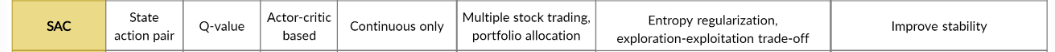

In [29]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

model_sac = agent.get_model("sac")
trained_sac = agent.train_model(model=model_sac, tb_log_name="sac", total_timesteps=10000 )

==============Model Training===========
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to tensorboard_log/sac/sac_3
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1|   1|LOW PROFIT     |$9,982         |$10,000        |0.00000%  |-0.00085% |99.82%    
   1|   2|LOW PROFIT     |$9,970         |$10,000        |-0.00089% |0.00245%  |99.70%    
   1|   3|LOW PROFIT     |$9,955         |$10,001        |-0.00163% |0.00648%  |99.54%    
   1|   5|LOW PROFIT     |$9,904         |$10,001        |-0.00132% |0.00819%  |99.03%    
   1|   6|LOW PROFIT     |$9,902         |$10,000        |-0.00181% |-0.00263% |99.02%    
   1|   7|LOW PROFIT     |$9,896         |$9,998         |-0.00388% |-0.02010% |98.98%    
   1|   8|LOW PROFIT     |$9,901         |$10,000        |-0.00392% |-0.00009% |99.01%    
   1|   9|update         |$9,901         

/usr/local/lib/python3.7/dist-packages/finrl/neo_finrl/env_stock_trading/env_stocktrading_stoploss.py:381: RuntimeWarning: divide by zero encountered in true_divide
  self.avg_buy_price = np.where(buys > 0, self.avg_buy_price + ((closings - self.avg_buy_price) / self.n_buys), self.avg_buy_price) #incremental average


   1|  10|LOW PROFIT     |$9,864         |$10,000        |-0.00251% |0.00010%  |98.64%    
   1|  11|LOW PROFIT     |$9,852         |$10,000        |-0.00236% |-0.00369% |98.52%    
   1|  12|LOW PROFIT     |$9,851         |$10,000        |-0.00504% |-0.00248% |98.51%    
   1|  13|LOW PROFIT     |$9,815         |$9,999         |-0.00246% |-0.00642% |98.16%    
   1|  15|LOW PROFIT     |$9,789         |$9,994         |-0.00295% |-0.06000% |97.95%    
   1|  16|LOW PROFIT     |$9,782         |$9,994         |-0.01189% |-0.06193% |97.88%    
   1|  17|LOW PROFIT     |$9,743         |$9,998         |-0.01009% |-0.02138% |97.45%    
   1|  18|LOW PROFIT     |$9,748         |$10,014        |-0.01079% |0.13922%  |97.34%    
   1|  19|update         |$9,748         |$10,014        |-0.01079% |0.13922%  |97.34%    
   1|  19|LOW PROFIT     |$9,752         |$10,012        |-0.00411% |0.12006%  |97.40%    
   1|  20|LOW PROFIT     |$9,752         |$10,015        |-0.00451% |0.15338%  |97.37%    

#Save Model

In [30]:
!mkdir -p saved_model
trained_sac.save('saved_model/my_modelBIST.h5') 

In [31]:
trained_sac

In [32]:
print("==============Start Trading===========")
e_trade_gym = StockTradingEnvStopLoss(df=trade, turbulence_threshold=250, **env_kwargs)



==============Start Trading===========
caching data
data cached!


In [33]:
df_account_value, df_actions = DRLAgent.DRL_prediction( model=trained_sac, environment = e_trade_gym)


EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION


/usr/local/lib/python3.7/dist-packages/finrl/neo_finrl/env_stock_trading/env_stocktrading_stoploss.py:381: RuntimeWarning: divide by zero encountered in true_divide
  self.avg_buy_price = np.where(buys > 0, self.avg_buy_price + ((closings - self.avg_buy_price) / self.n_buys), self.avg_buy_price) #incremental average


   1|   9|update         |$9,438         |$10,000        |0.00917%  |-0.00249% |94.39%    
   1|  19|update         |$8,736         |$10,082        |0.03168%  |0.81582%  |86.66%    
   1|  29|update         |$8,034         |$10,036        |0.00528%  |0.35704%  |80.06%    
   1|  39|update         |$7,332         |$10,270        |0.06820%  |2.70019%  |71.39%    
   1|  49|update         |$6,630         |$10,322        |0.06292%  |3.22399%  |64.23%    
   1|  59|update         |$5,928         |$10,469        |0.07704%  |4.68504%  |56.63%    
   1|  69|update         |$5,226         |$10,266        |0.01192%  |2.65973%  |50.90%    
   1|  79|update         |$4,524         |$9,968         |-0.02811% |-0.31567% |45.38%    
   1|  89|update         |$3,822         |$10,116        |-0.00252% |1.15666%  |37.78%    
   1|  99|update         |$3,119         |$10,189        |0.00741%  |1.88548%  |30.62%    
   1| 109|update         |$2,417         |$10,092        |0.01197%  |0.91616%  |23.95%    

In [34]:
trade

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,5.800000,5.810000,5.700000,5.720000,5.578002,43319180.0,AKBNK.IS,2020-07-27,-0.032535,45.321645,-107.064136,3.281478,6.141735
0,22.240000,22.540001,22.100000,22.160000,20.744827,10243494.0,ARCLK.IS,2020-07-27,1.084334,71.838800,145.124012,62.664200,6.141735
0,74.699997,75.900002,74.250000,74.300003,69.351898,2675233.0,BIMAS.IS,2020-07-27,1.951131,65.861834,192.733720,48.082447,6.141735
0,8.410000,8.510000,8.390000,8.470000,7.452500,36658368.0,EREGL.IS,2020-07-27,0.000343,50.769015,-40.977438,1.932329,6.141735
0,7.950000,7.960000,7.770000,7.800000,7.635209,98366875.0,GARAN.IS,2020-07-27,-0.083367,43.797485,-114.132586,16.189562,6.141735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,67.699997,71.949997,67.199997,71.400002,71.400002,3505926.0,PGSUS.IS,2021-07-27,-2.136392,44.699076,-115.962311,31.513849,7.048507
248,9.070000,9.300000,9.020000,9.290000,9.290000,17634418.0,SAHOL.IS,2021-07-27,0.000826,53.078843,5.758155,11.416987,7.048507
248,29.680000,30.299999,29.340000,29.540001,29.540001,15605997.0,SASA.IS,2021-07-27,-0.567082,47.213518,-26.532921,13.879146,7.048507
248,3.430000,3.440000,3.390000,3.420000,3.420000,30871452.0,VAKBN.IS,2021-07-27,-0.036190,42.210935,-143.798826,35.035782,7.048507


In [35]:
df_actions

,date,actions,transactions
0,2020-12-28,"[-64.6999979019165, 307.00000762939453, 741.50...","[-0.0, 0.3257328909278673, 0.1348617639139215,..."
1,2020-12-29,"[-65.59999942779541, 303.4000015258789, 735.99...","[-0.0, 0.3295978889158653, 0.13586956803424602..."
2,2020-12-30,"[-65.19999980926514, 300.5999946594238, 730.99...","[-0.0, 0.3326680032489648, 0.13679890846427592..."
3,2020-12-31,"[-65.50000190734863, 306.8000030517578, 737.5,...","[-0.0, 0.32594523795728186, 0.1355932203389830..."
4,2021-01-04,"[-66.19999885559082, 305.79999923706055, 756.9...","[-0.0, 0.32701111919388387, 0.1321004016266636..."
...,...,...,...
137,2021-07-14,"[-53.20000171661377, 327.20001220703125, 632.5...","[-0.0, 0.3056234604805772, 0.15810276679841898..."
138,2021-07-16,"[-52.89999961853027, 323.1999969482422, 612.99...","[-0.0, 0.3094059435155693, 0.16313213906133678..."
139,2021-07-19,"[-52.39999771118164, 323.4000015258789, 612.00...","[-0.0, 0.3092145934699319, 0.16339869077347535..."
140,2021-07-26,"[-52.89999961853027, 327.00000762939453, 617.0...","[-0.0, 0.30581039041850727, 0.1620745522908740..."


In [36]:
df_account_value["cash"].min()

100.39000000001788

In [37]:
df_account_value

,cash,asset_value,total_assets,reward,date
0,10000.00,0.000000,10000.000000,0.000000,2020-12-28
1,9929.79,70.077807,9999.867807,0.000000,2020-12-29
2,9859.58,139.640852,9999.220852,-0.000007,2020-12-30
3,9789.37,210.730392,10000.100392,-0.000026,2020-12-31
4,9719.16,283.853505,10003.013505,0.000003,2021-01-04
...,...,...,...,...,...
137,381.23,9506.712345,9887.942345,-0.000471,2021-07-14
138,311.02,9380.842074,9691.862074,-0.000533,2021-07-16
139,240.81,9521.759047,9762.569047,-0.000718,2021-07-19
140,170.60,9830.852046,10001.452046,-0.000718,2021-07-26


In [38]:
y = df_actions["actions"][0].sum()

In [39]:
x = df_actions["transactions"][0].sum()

In [40]:
e_trade_gym
test_env, test_obs = e_trade_gym.get_sb_env()


In [41]:
df_account_value

profit_list = []
ac_val = list(df_account_value["total_assets"])
print(ac_val)
turn =len(ac_val)
for i in range(turn):
  
  if i != turn-1:

    diff = ac_val[i+1]  - ac_val[i]
    profit_list.append(diff)
  else:
    profit_list.append(float(0))
    
print(profit_list)


[10000.0, 9999.86780677899, 9999.2208522711, 10000.100391667027, 10003.013505324856, 10007.888768515035, 10008.174609786638, 10007.337490796646, 9999.750672911741, 10014.347246055766, 10031.704360207748, 10035.324452281578, 10034.354055752543, 10044.178148137784, 10057.186773738747, 10067.19585301592, 10047.082320379866, 10057.027765609526, 10081.581745794572, 10082.280816713244, 10072.014700351581, 10050.160103648197, 10038.511854814727, 10052.002144685808, 9989.5208232078, 10044.508182387932, 10010.946187165113, 10014.797228828971, 10035.703651655565, 10076.679783455073, 10074.865842341267, 10089.425857385344, 10123.02384571916, 10144.7385717223, 10163.563547948179, 10144.492646267132, 10168.212565203501, 10259.174677700621, 10270.018646365961, 10353.793986087872, 10410.38142816606, 10403.784623701664, 10307.794183986847, 10229.968316643117, 10210.011089445648, 10271.617552902597, 10242.76786950709, 10302.017506175262, 10322.399205690335, 10325.656507057476, 10374.523302355745, 10356

In [42]:
new_df = df_account_value.copy()

new_df["diff"] = np.array(profit_list)

new_df

,cash,asset_value,total_assets,reward,date,diff
0,10000.00,0.000000,10000.000000,0.000000,2020-12-28,-0.132193
1,9929.79,70.077807,9999.867807,0.000000,2020-12-29,-0.646955
2,9859.58,139.640852,9999.220852,-0.000007,2020-12-30,0.879539
3,9789.37,210.730392,10000.100392,-0.000026,2020-12-31,2.913114
4,9719.16,283.853505,10003.013505,0.000003,2021-01-04,4.875263
...,...,...,...,...,...,...
137,381.23,9506.712345,9887.942345,-0.000471,2021-07-14,-196.080271
138,311.02,9380.842074,9691.862074,-0.000533,2021-07-16,70.706973
139,240.81,9521.759047,9762.569047,-0.000718,2021-07-19,238.882999
140,170.60,9830.852046,10001.452046,-0.000718,2021-07-26,-39.536282


In [43]:
%matplotlib inline

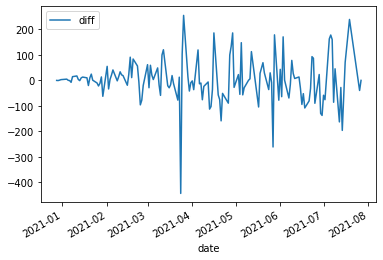

In [44]:
# hesaptaki günlük kar-zarar grafiği
new_df.plot(x='date', y='diff', kind = 'line')

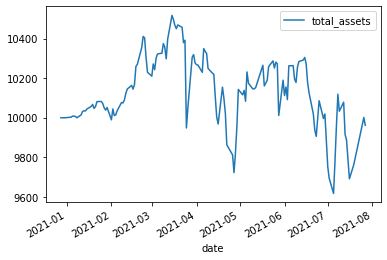

In [45]:
# total hesaptaki maliyetin değişimi
new_df.plot(x='date', y='total_assets', kind = 'line')

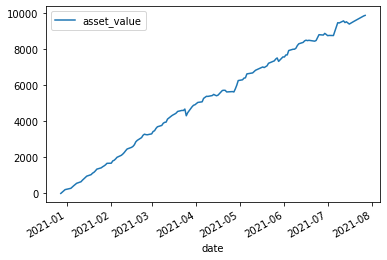

In [60]:
# total hesaptaki maliyetin değişimi
new_df.plot(x='date', y='asset_value', kind = 'line')

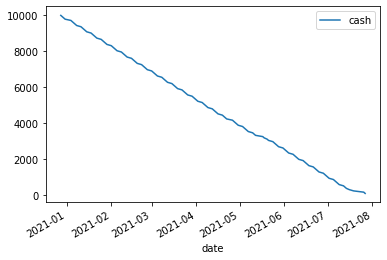

In [62]:
new_df.plot(x='date', y='cash', kind = 'line')

# 1 Day test

In [47]:
print("==============Start Trading===========")
trade_1day = data_split(processed_full, "2021-07-10", "2021-07-17")

e_trade_gym_1day = StockTradingEnvStopLoss(df=trade_1day, turbulence_threshold=250, **env_kwargs)

df_account_value_1day, df_actions_1day = DRLAgent.DRL_prediction( model=trained_sac, environment = e_trade_gym_1day)


==============Start Trading===========
caching data
data cached!
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1|   2|Last Date      |$9,930         |$10,001        |0.00717%  |0.01434%  |99.28%    
environment/GainLoss_pct 0.014335778843843627
environment/total_assets 10001
environment/total_reward_pct 0.014335778843843627
environment/total_trades 36.0
environment/actual_num_trades 7.0
environment/avg_daily_trades 18.0
environment/avg_daily_trades_per_asset 1.5
environment/completed_steps 2
environment/sum_rewards 0.0
environment/cash_proportion 0.992836669130833
hit end!


/usr/local/lib/python3.7/dist-packages/finrl/neo_finrl/env_stock_trading/env_stocktrading_stoploss.py:381: RuntimeWarning: divide by zero encountered in true_divide
  self.avg_buy_price = np.where(buys > 0, self.avg_buy_price + ((closings - self.avg_buy_price) / self.n_buys), self.avg_buy_price) #incremental average


In [48]:
import os
cwd = os.getcwd()
cwd

'/content'

In [49]:
import os
os.chdir('/content/saved_model')


with open("./" + "/df_account_value_BIST" + now + ".csv", 'a') as f1:
    df_account_value.to_csv(f1, header=False)

with open("./"+ "/df_actions_BIST" + now + ".csv", 'a') as f2:
    df_actions.to_csv(f2, header=False)




#Backtesting 

In [50]:
# print("==============Get Backtest Results===========")
# perf_stats_all = backtest_stats(df_account_value)
# perf_stats_all = pd.DataFrame(perf_stats_all)
# perf_stats_all.to_csv("./" +"/perf_stats_all_BIST" + now + ".csv")


 #Understanding Format of Variables:

In [51]:
train

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,6.182181,6.182181,6.122160,6.165032,5.510608,13466375.0,AKBNK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
0,14.750000,14.950000,14.500000,14.600000,11.878804,1976842.0,ARCLK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
0,23.525000,23.799999,23.325001,23.600000,19.072001,628882.0,BIMAS.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
0,3.990000,4.040000,3.960000,4.040000,1.965522,6776403.0,EREGL.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
0,7.900000,7.910000,7.740000,7.760000,6.942376,63095366.0,GARAN.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,51.000000,51.900002,50.650002,51.349998,51.349998,2002048.0,PGSUS.IS,2020-07-24,-1.015999,46.712444,-87.886699,5.067109,2.554014
1281,9.150000,9.150000,9.050000,9.100000,8.755303,5455417.0,SAHOL.IS,2020-07-24,0.065249,52.595700,-79.706951,3.445070,2.554014
1281,10.004468,10.263843,9.930361,10.123040,10.123040,29892348.0,SASA.IS,2020-07-24,0.633239,68.646562,138.956885,47.425085,2.554014
1281,4.890000,4.920000,4.840000,4.880000,4.880000,39839221.0,VAKBN.IS,2020-07-24,-0.010792,48.479858,-67.830976,7.872245,2.554014


In [52]:
trade

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,5.800000,5.810000,5.700000,5.720000,5.578002,43319180.0,AKBNK.IS,2020-07-27,-0.032535,45.321645,-107.064136,3.281478,6.141735
0,22.240000,22.540001,22.100000,22.160000,20.744827,10243494.0,ARCLK.IS,2020-07-27,1.084334,71.838800,145.124012,62.664200,6.141735
0,74.699997,75.900002,74.250000,74.300003,69.351898,2675233.0,BIMAS.IS,2020-07-27,1.951131,65.861834,192.733720,48.082447,6.141735
0,8.410000,8.510000,8.390000,8.470000,7.452500,36658368.0,EREGL.IS,2020-07-27,0.000343,50.769015,-40.977438,1.932329,6.141735
0,7.950000,7.960000,7.770000,7.800000,7.635209,98366875.0,GARAN.IS,2020-07-27,-0.083367,43.797485,-114.132586,16.189562,6.141735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,67.699997,71.949997,67.199997,71.400002,71.400002,3505926.0,PGSUS.IS,2021-07-27,-2.136392,44.699076,-115.962311,31.513849,7.048507
248,9.070000,9.300000,9.020000,9.290000,9.290000,17634418.0,SAHOL.IS,2021-07-27,0.000826,53.078843,5.758155,11.416987,7.048507
248,29.680000,30.299999,29.340000,29.540001,29.540001,15605997.0,SASA.IS,2021-07-27,-0.567082,47.213518,-26.532921,13.879146,7.048507
248,3.430000,3.440000,3.390000,3.420000,3.420000,30871452.0,VAKBN.IS,2021-07-27,-0.036190,42.210935,-143.798826,35.035782,7.048507


In [53]:
e_train_gym

In [54]:
agent

In [55]:
model_sac

In [56]:
trained_sac

In [57]:
e_trade_gym

In [58]:
df_account_value

,cash,asset_value,total_assets,reward,date
0,10000.00,0.000000,10000.000000,0.000000,2020-12-28
1,9929.79,70.077807,9999.867807,0.000000,2020-12-29
2,9859.58,139.640852,9999.220852,-0.000007,2020-12-30
3,9789.37,210.730392,10000.100392,-0.000026,2020-12-31
4,9719.16,283.853505,10003.013505,0.000003,2021-01-04
...,...,...,...,...,...
137,381.23,9506.712345,9887.942345,-0.000471,2021-07-14
138,311.02,9380.842074,9691.862074,-0.000533,2021-07-16
139,240.81,9521.759047,9762.569047,-0.000718,2021-07-19
140,170.60,9830.852046,10001.452046,-0.000718,2021-07-26


In [59]:
df_actions

,date,actions,transactions
0,2020-12-28,"[-64.6999979019165, 307.00000762939453, 741.50...","[-0.0, 0.3257328909278673, 0.1348617639139215,..."
1,2020-12-29,"[-65.59999942779541, 303.4000015258789, 735.99...","[-0.0, 0.3295978889158653, 0.13586956803424602..."
2,2020-12-30,"[-65.19999980926514, 300.5999946594238, 730.99...","[-0.0, 0.3326680032489648, 0.13679890846427592..."
3,2020-12-31,"[-65.50000190734863, 306.8000030517578, 737.5,...","[-0.0, 0.32594523795728186, 0.1355932203389830..."
4,2021-01-04,"[-66.19999885559082, 305.79999923706055, 756.9...","[-0.0, 0.32701111919388387, 0.1321004016266636..."
...,...,...,...
137,2021-07-14,"[-53.20000171661377, 327.20001220703125, 632.5...","[-0.0, 0.3056234604805772, 0.15810276679841898..."
138,2021-07-16,"[-52.89999961853027, 323.1999969482422, 612.99...","[-0.0, 0.3094059435155693, 0.16313213906133678..."
139,2021-07-19,"[-52.39999771118164, 323.4000015258789, 612.00...","[-0.0, 0.3092145934699319, 0.16339869077347535..."
140,2021-07-26,"[-52.89999961853027, 327.00000762939453, 617.0...","[-0.0, 0.30581039041850727, 0.1620745522908740..."
